In [1]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from tqdm import tqdm

import importlib

In [2]:
import ensembles

importlib.reload(ensembles)

<module 'ensembles' from 'C:\\Users\\Vladimir\\PycharmProjects\\ML_Ensembles\\experiments\\ensembles\\__init__.py'>

In [3]:
data = pd.read_csv('kc_house_data.csv')

data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
y = data.price.to_numpy()
X = data.drop(columns=['price'])
X['date'] = pd.to_datetime(X.date.apply(lambda s: f"{s[0:4]}-{s[4:6]}-{s[6:8]}")).apply(lambda dt: dt.value)
X.drop(columns='id', inplace=True)

X.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1413158400000000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1418083200000000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,1424822400000000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,1418083200000000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1424217600000000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


_sqft\_living_ --- жилая площадь (в квадратных футах)
_sqft\_lot_ --- площадь участка (в квадратных футах)
_waterfront_ --- дом у набережной или дом у озера, реки
_sqft\_living15_ --- средняя жилая площадь у ближайших 15 домов
_sqft\_lot15_ --- средняя площадь участка и ближайших 15 домов

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"{X_train.shape=}")
print(f"{X_test.shape=}")

X_train.shape=(17290, 19)
X_test.shape=(4323, 19)


In [6]:
boosting = ensembles.GradientBoostingMSE(
    n_estimators=1_000,
    feature_subsample_size=12,
    random_state=42,
    max_depth=7,
    learning_rate=0.05
)

boosting = Pipeline([
    ('scale', StandardScaler()),
    ('forest', boosting)
])

boosting.fit(X_train, y_train)

i=  0	np.linalg.norm(S)=81180183.715359225869
i=  1	np.linalg.norm(S)=77371823.153245389462
i=  2	np.linalg.norm(S)=73763263.771889269352
i=  3	np.linalg.norm(S)=70328242.732109054923
i=  4	np.linalg.norm(S)=67057556.316904388368
i=  5	np.linalg.norm(S)=63963772.721109867096
i=  6	np.linalg.norm(S)=61020803.466053776443
i=  7	np.linalg.norm(S)=58243699.598232612014
i=  8	np.linalg.norm(S)=55593997.810448154807
i=  9	np.linalg.norm(S)=53093029.944404222071
i= 10	np.linalg.norm(S)=50712724.534064345062
i= 11	np.linalg.norm(S)=48464567.222485899925
i= 12	np.linalg.norm(S)=46323448.508948192000
i= 13	np.linalg.norm(S)=44306803.708253234625
i= 14	np.linalg.norm(S)=42385495.948313251138
i= 15	np.linalg.norm(S)=40574330.350003145635
i= 16	np.linalg.norm(S)=38855435.126153498888
i= 17	np.linalg.norm(S)=37233412.420752838254
i= 18	np.linalg.norm(S)=35691069.747159495950
i= 19	np.linalg.norm(S)=34229221.020649358630
i= 20	np.linalg.norm(S)=32847725.578525058925
i= 21	np.linalg.norm(S)=31538868.4

Pipeline(steps=[('scale', StandardScaler()),
                ('forest',
                 <ensembles.GradientBoostingMSE object at 0x000001F27C810210>)])

In [7]:
y_pred = boosting.predict(X_test)
print(f"MSE: {mean_squared_error(y_true=y_test, y_pred=y_pred):.0f}")
print(f"r^2: {r2_score(y_true=y_test, y_pred=y_pred):.4f}")

MSE: 35060
r^2: 0.8753


100%|██████████| 999/999 [02:04<00:00,  8.03it/s]


Text(0.5, 1.0, 'R^2 score')

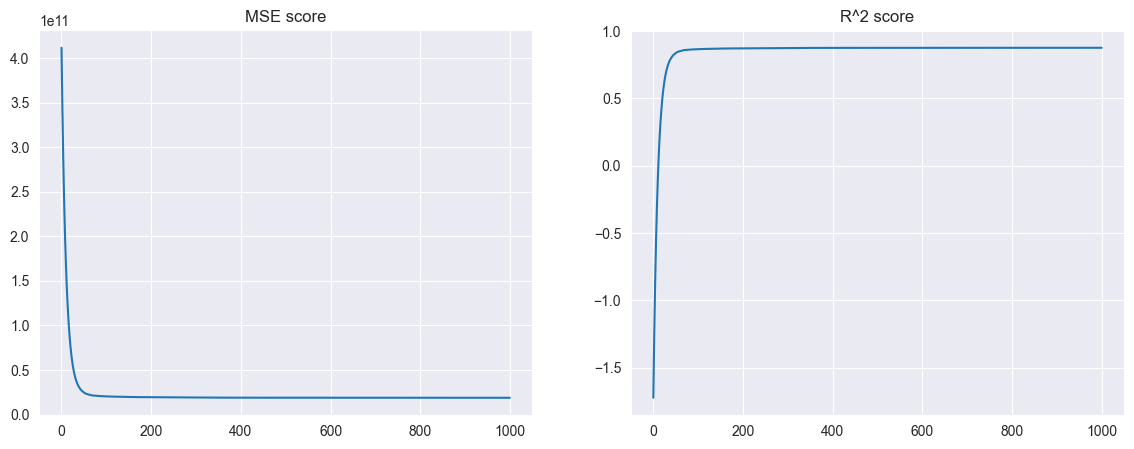

In [8]:
_, ax = plt.subplots(ncols=2, figsize=(14, 5))

estimators_cnt = np.arange(1_000 - 1) + 1
mse_score_ls = np.zeros_like(estimators_cnt, dtype=np.float64)
r2_score_ls = np.zeros_like(estimators_cnt, dtype=np.float64)

for i in tqdm(estimators_cnt):
    y_pred = boosting.predict(X_test, **{'estimators_c': i})
    mse_score_ls[i-1] = mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2_score_ls[i-1] = r2_score(y_true=y_test, y_pred=y_pred)
    
ax[0].plot(estimators_cnt, mse_score_ls)
ax[0].set_title("MSE score")

ax[1].plot(estimators_cnt, r2_score_ls)
ax[1].set_title("R^2 score")

In [9]:
feat_cnt = np.arange(X_train.shape[1] - 1) + 1
mse_score_ls = np.zeros_like(feat_cnt, dtype=np.float64)
r2_score_ls = np.zeros_like(feat_cnt, dtype=np.float64)

for i in tqdm(feat_cnt):
    mse_score_raw = []
    r2_score_raw = []
    
    for seed in [42, 11, 5647, 456, 9195, 2023]:
        boosting = ensembles.GradientBoostingMSE(
            n_estimators=250,
            feature_subsample_size=i,
            random_state=42,
            max_depth=None,
            learning_rate=0.05
        )
        
        boosting = Pipeline([
            ('scale', StandardScaler()),
            ('forest', boosting)
        ])
        
        boosting.fit(X_train, y_train)
        mse_score_raw.append(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_score_raw.append(r2_score(y_true=y_test, y_pred=y_pred))
    
    y_pred = boosting.predict(X_test)
    mse_score_ls[i-1] = np.mean(mse_score_raw)
    r2_score_ls[i-1] = np.mean(r2_score_raw)

  0%|          | 0/18 [00:00<?, ?it/s]

i=  0	np.linalg.norm(S)=80940272.604389324784
i=  1	np.linalg.norm(S)=76893259.088606104255
i=  2	np.linalg.norm(S)=73048596.254634991288
i=  3	np.linalg.norm(S)=69396167.500509917736
i=  4	np.linalg.norm(S)=65926359.181409835815
i=  5	np.linalg.norm(S)=62630041.230728156865
i=  6	np.linalg.norm(S)=59498539.169191747904
i=  7	np.linalg.norm(S)=56523612.258050307631
i=  8	np.linalg.norm(S)=53697431.745429053903
i=  9	np.linalg.norm(S)=51012560.622829660773
i= 10	np.linalg.norm(S)=48461932.601064212620
i= 11	np.linalg.norm(S)=46038835.973751693964
i= 12	np.linalg.norm(S)=43736906.550227649510
i= 13	np.linalg.norm(S)=41550061.470063284039
i= 14	np.linalg.norm(S)=39472558.396560117602
i= 15	np.linalg.norm(S)=37498930.521669030190
i= 16	np.linalg.norm(S)=35623987.653778180480
i= 17	np.linalg.norm(S)=33842788.338977076113
i= 18	np.linalg.norm(S)=32150648.933990251273
i= 19	np.linalg.norm(S)=30543131.356980178505
i= 20	np.linalg.norm(S)=29015974.852610006928
i= 21	np.linalg.norm(S)=27565176.1

  6%|▌         | 1/18 [00:59<16:51, 59.50s/it]

i=  0	np.linalg.norm(S)=80940262.050958663225
i=  1	np.linalg.norm(S)=76893248.980110511184
i=  2	np.linalg.norm(S)=73048592.353034630418
i=  3	np.linalg.norm(S)=69396162.791456639767
i=  4	np.linalg.norm(S)=65926357.914199888706
i=  5	np.linalg.norm(S)=62630040.041792146862
i=  6	np.linalg.norm(S)=59498544.232736930251
i=  7	np.linalg.norm(S)=56523617.598304972053
i=  8	np.linalg.norm(S)=53697436.763941310346
i=  9	np.linalg.norm(S)=51012566.482090435922
i= 10	np.linalg.norm(S)=48461938.172590896487
i= 11	np.linalg.norm(S)=46038858.607200667262
i= 12	np.linalg.norm(S)=43736916.127923391759
i= 13	np.linalg.norm(S)=41550070.383363954723
i= 14	np.linalg.norm(S)=39472566.864195756614
i= 15	np.linalg.norm(S)=37498938.558186426759
i= 16	np.linalg.norm(S)=35623993.333928555250
i= 17	np.linalg.norm(S)=33842793.780556552112
i= 18	np.linalg.norm(S)=32150656.113110400736
i= 19	np.linalg.norm(S)=30543123.455185838044
i= 20	np.linalg.norm(S)=29015970.402390688658
i= 21	np.linalg.norm(S)=27565171.8

 11%|█         | 2/18 [02:18<18:56, 71.00s/it]

i=  0	np.linalg.norm(S)=80940262.973375037313
i=  1	np.linalg.norm(S)=76893249.939142540097
i=  2	np.linalg.norm(S)=73048587.652004271746
i=  3	np.linalg.norm(S)=69396158.269404053688
i=  4	np.linalg.norm(S)=65926350.355933867395
i=  5	np.linalg.norm(S)=62630032.867264993489
i=  6	np.linalg.norm(S)=59498531.385945655406
i=  7	np.linalg.norm(S)=56523604.816648371518
i=  8	np.linalg.norm(S)=53697426.320362545550
i=  9	np.linalg.norm(S)=51012555.004344418645
i= 10	np.linalg.norm(S)=48461927.254127196968
i= 11	np.linalg.norm(S)=46038830.928621321917
i= 12	np.linalg.norm(S)=43736889.478525444865
i= 13	np.linalg.norm(S)=41550050.956388659775
i= 14	np.linalg.norm(S)=39472548.408569224179
i= 15	np.linalg.norm(S)=37498920.988140754402
i= 16	np.linalg.norm(S)=35623976.282276459038
i= 17	np.linalg.norm(S)=33842777.480754241347
i= 18	np.linalg.norm(S)=32150638.726336807013
i= 19	np.linalg.norm(S)=30543106.831683911383
i= 20	np.linalg.norm(S)=29015951.490099716932
i= 21	np.linalg.norm(S)=27565153.9

 17%|█▋        | 3/18 [04:01<21:27, 85.81s/it]

i=  0	np.linalg.norm(S)=80940261.900384649634
i=  1	np.linalg.norm(S)=76893248.805365413427
i=  2	np.linalg.norm(S)=73048586.418367207050
i=  3	np.linalg.norm(S)=69396157.205161958933
i=  4	np.linalg.norm(S)=65926349.344903878868
i=  5	np.linalg.norm(S)=62630031.877658680081
i=  6	np.linalg.norm(S)=59498530.283775739372
i=  7	np.linalg.norm(S)=56523604.955829158425
i=  8	np.linalg.norm(S)=53697424.732212021947
i=  9	np.linalg.norm(S)=51012553.495601415634
i= 10	np.linalg.norm(S)=48461925.868897587061
i= 11	np.linalg.norm(S)=46038829.575452707708
i= 12	np.linalg.norm(S)=43736888.112952910364
i= 13	np.linalg.norm(S)=41550043.707305260003
i= 14	np.linalg.norm(S)=39472541.540297791362
i= 15	np.linalg.norm(S)=37498914.463282898068
i= 16	np.linalg.norm(S)=35623968.740118756890
i= 17	np.linalg.norm(S)=33842770.315704427660
i= 18	np.linalg.norm(S)=32150632.841984126717
i= 19	np.linalg.norm(S)=30543101.199884921312
i= 20	np.linalg.norm(S)=29015946.164504949003
i= 21	np.linalg.norm(S)=27565148.8

 22%|██▏       | 4/18 [06:09<23:50, 102.19s/it]

i=  0	np.linalg.norm(S)=80940261.930499449372
i=  1	np.linalg.norm(S)=76893248.833974480629
i=  2	np.linalg.norm(S)=73048586.392275750637
i=  3	np.linalg.norm(S)=69396157.072661951184
i=  4	np.linalg.norm(S)=65926349.219028867781
i=  5	np.linalg.norm(S)=62630031.803749851882
i=  6	np.linalg.norm(S)=59498530.293477460742
i=  7	np.linalg.norm(S)=56523603.778803586960
i=  8	np.linalg.norm(S)=53697423.633252218366
i=  9	np.linalg.norm(S)=51012552.452348798513
i= 10	np.linalg.norm(S)=48461924.891151010990
i= 11	np.linalg.norm(S)=46038828.646593466401
i= 12	np.linalg.norm(S)=43736889.964373193681
i= 13	np.linalg.norm(S)=41550045.466154530644
i= 14	np.linalg.norm(S)=39472543.284635774791
i= 15	np.linalg.norm(S)=37498916.120403982699
i= 16	np.linalg.norm(S)=35623970.364410474896
i= 17	np.linalg.norm(S)=33842771.858781553805
i= 18	np.linalg.norm(S)=32150633.265842482448
i= 19	np.linalg.norm(S)=30543101.602550357580
i= 20	np.linalg.norm(S)=29015946.547037106007
i= 21	np.linalg.norm(S)=27565149.2

 28%|██▊       | 5/18 [08:41<26:04, 120.33s/it]

i=  0	np.linalg.norm(S)=80940261.900384649634
i=  1	np.linalg.norm(S)=76893248.805365413427
i=  2	np.linalg.norm(S)=73048586.365097135305
i=  3	np.linalg.norm(S)=69396157.046842277050
i=  4	np.linalg.norm(S)=65926349.194500170648
i=  5	np.linalg.norm(S)=62630031.734775155783
i=  6	np.linalg.norm(S)=59498530.347270727158
i=  7	np.linalg.norm(S)=56523603.829907193780
i=  8	np.linalg.norm(S)=53697423.638411827385
i=  9	np.linalg.norm(S)=51012552.505079619586
i= 10	np.linalg.norm(S)=48461924.879825636744
i= 11	np.linalg.norm(S)=46038828.635834358633
i= 12	np.linalg.norm(S)=43736887.204042643309
i= 13	np.linalg.norm(S)=41550042.843840502203
i= 14	np.linalg.norm(S)=39472540.701648481190
i= 15	np.linalg.norm(S)=37498913.666566058993
i= 16	np.linalg.norm(S)=35623967.983237758279
i= 17	np.linalg.norm(S)=33842769.584075868130
i= 18	np.linalg.norm(S)=32150631.104872070253
i= 19	np.linalg.norm(S)=30543099.731451336294
i= 20	np.linalg.norm(S)=29015944.744878765196
i= 21	np.linalg.norm(S)=27565147.5

 33%|███▎      | 6/18 [11:34<27:39, 138.29s/it]

i=  0	np.linalg.norm(S)=80940262.269290968776
i=  1	np.linalg.norm(S)=76893249.155826434493
i=  2	np.linalg.norm(S)=73048586.698035106063
i=  3	np.linalg.norm(S)=69396157.363133341074
i=  4	np.linalg.norm(S)=65926349.494976684451
i=  5	np.linalg.norm(S)=62630032.020227842033
i=  6	np.linalg.norm(S)=59498530.419216454029
i=  7	np.linalg.norm(S)=56523603.898255631328
i=  8	np.linalg.norm(S)=53697423.703342847526
i=  9	np.linalg.norm(S)=51012552.518934898078
i= 10	np.linalg.norm(S)=48461924.892988152802
i= 11	np.linalg.norm(S)=46038833.851535342634
i= 12	np.linalg.norm(S)=43736892.158958569169
i= 13	np.linalg.norm(S)=41550047.551010638475
i= 14	np.linalg.norm(S)=39472545.173460111022
i= 15	np.linalg.norm(S)=37498917.914787098765
i= 16	np.linalg.norm(S)=35623972.033733986318
i= 17	np.linalg.norm(S)=33842773.432047277689
i= 18	np.linalg.norm(S)=32150634.760444916785
i= 19	np.linalg.norm(S)=30543103.044695969671
i= 20	np.linalg.norm(S)=29015947.892461173236
i= 21	np.linalg.norm(S)=27565150.5

 39%|███▉      | 7/18 [14:51<28:52, 157.48s/it]

i=  0	np.linalg.norm(S)=80940261.900384649634
i=  1	np.linalg.norm(S)=76893248.805365413427
i=  2	np.linalg.norm(S)=73048589.653708785772
i=  3	np.linalg.norm(S)=69396160.171023339033
i=  4	np.linalg.norm(S)=65926352.162472181022
i=  5	np.linalg.norm(S)=62630034.554348565638
i=  6	np.linalg.norm(S)=59498532.826631136239
i=  7	np.linalg.norm(S)=56523606.185299582779
i=  8	np.linalg.norm(S)=53697425.876034602523
i=  9	np.linalg.norm(S)=51012554.582232870162
i= 10	np.linalg.norm(S)=48461926.853121228516
i= 11	np.linalg.norm(S)=46038830.510465167463
i= 12	np.linalg.norm(S)=43736888.984941914678
i= 13	np.linalg.norm(S)=41550044.535694807768
i= 14	np.linalg.norm(S)=39472542.308910079300
i= 15	np.linalg.norm(S)=37498915.193464569747
i= 16	np.linalg.norm(S)=35623969.530813015997
i= 17	np.linalg.norm(S)=33842771.054272361100
i= 18	np.linalg.norm(S)=32150632.501558743417
i= 19	np.linalg.norm(S)=30543100.876480810344
i= 20	np.linalg.norm(S)=29015945.832656767219
i= 21	np.linalg.norm(S)=27565148.5

 44%|████▍     | 8/18 [18:35<29:44, 178.41s/it]

i=  0	np.linalg.norm(S)=80940261.900384649634
i=  1	np.linalg.norm(S)=76893250.636345386505
i=  2	np.linalg.norm(S)=73048588.104528114200
i=  3	np.linalg.norm(S)=69396158.699301689863
i=  4	np.linalg.norm(S)=65926350.764336615801
i=  5	np.linalg.norm(S)=62630033.931013137102
i=  6	np.linalg.norm(S)=59498532.234462477267
i=  7	np.linalg.norm(S)=56523605.622739352286
i=  8	np.linalg.norm(S)=53697425.341602385044
i=  9	np.linalg.norm(S)=51012554.074522271752
i= 10	np.linalg.norm(S)=48461926.370796158910
i= 11	np.linalg.norm(S)=46038830.052256353199
i= 12	np.linalg.norm(S)=43736888.549643531442
i= 13	np.linalg.norm(S)=41550044.122161351144
i= 14	np.linalg.norm(S)=39472541.916053287685
i= 15	np.linalg.norm(S)=37498914.847596392035
i= 16	np.linalg.norm(S)=35623970.708990126848
i= 17	np.linalg.norm(S)=33842772.173540621996
i= 18	np.linalg.norm(S)=32150633.564863588661
i= 19	np.linalg.norm(S)=30543101.886620409787
i= 20	np.linalg.norm(S)=29015946.792289391160
i= 21	np.linalg.norm(S)=27565149.4

 50%|█████     | 9/18 [22:39<29:50, 198.92s/it]

i=  0	np.linalg.norm(S)=80940261.900384649634
i=  1	np.linalg.norm(S)=76893248.861439168453
i=  2	np.linalg.norm(S)=73048586.418367207050
i=  3	np.linalg.norm(S)=69396157.153522610664
i=  4	np.linalg.norm(S)=65926349.295846492052
i=  5	np.linalg.norm(S)=62630031.831054151058
i=  6	np.linalg.norm(S)=59498530.239501453936
i=  7	np.linalg.norm(S)=56523604.064011014998
i=  8	np.linalg.norm(S)=53697423.860810458660
i=  9	np.linalg.norm(S)=51012552.667769938707
i= 10	np.linalg.norm(S)=48461925.034381441772
i= 11	np.linalg.norm(S)=46038828.782662376761
i= 12	np.linalg.norm(S)=43736887.343529254198
i= 13	np.linalg.norm(S)=41550042.976352781057
i= 14	np.linalg.norm(S)=39472540.827535152435
i= 15	np.linalg.norm(S)=37498913.786158390343
i= 16	np.linalg.norm(S)=35623968.096850477159
i= 17	np.linalg.norm(S)=33842769.692007951438
i= 18	np.linalg.norm(S)=32150631.207886032760
i= 19	np.linalg.norm(S)=30543099.647491730750
i= 20	np.linalg.norm(S)=29015944.665117144585
i= 21	np.linalg.norm(S)=27565147.4

 56%|█████▌    | 10/18 [27:11<29:32, 221.61s/it]

i=  0	np.linalg.norm(S)=80940261.900384649634
i=  1	np.linalg.norm(S)=76893248.805365413427
i=  2	np.linalg.norm(S)=73048586.365097135305
i=  3	np.linalg.norm(S)=69396157.046842277050
i=  4	np.linalg.norm(S)=65926349.194500170648
i=  5	np.linalg.norm(S)=62630031.734775155783
i=  6	np.linalg.norm(S)=59498530.148036397994
i=  7	np.linalg.norm(S)=56523603.640634581447
i=  8	np.linalg.norm(S)=53697424.062960796058
i=  9	np.linalg.norm(S)=51012552.859812758863
i= 10	np.linalg.norm(S)=48461925.216822125018
i= 11	np.linalg.norm(S)=46038828.955981023610
i= 12	np.linalg.norm(S)=43736887.508181966841
i= 13	np.linalg.norm(S)=41550043.132772862911
i= 14	np.linalg.norm(S)=39472540.976134225726
i= 15	np.linalg.norm(S)=37498913.927327513695
i= 16	np.linalg.norm(S)=35623968.230961136520
i= 17	np.linalg.norm(S)=33842769.819413080812
i= 18	np.linalg.norm(S)=32150631.328442424536
i= 19	np.linalg.norm(S)=30543099.762020301074
i= 20	np.linalg.norm(S)=29015944.773919288069
i= 21	np.linalg.norm(S)=27565147.5

 61%|██████    | 11/18 [32:05<28:25, 243.64s/it]

i=  0	np.linalg.norm(S)=80940261.900384649634
i=  1	np.linalg.norm(S)=76893248.805365413427
i=  2	np.linalg.norm(S)=73048586.418367207050
i=  3	np.linalg.norm(S)=69396157.097448840737
i=  4	np.linalg.norm(S)=65926349.242576412857
i=  5	np.linalg.norm(S)=62630031.780447579920
i=  6	np.linalg.norm(S)=59498530.191425211728
i=  7	np.linalg.norm(S)=56523603.681853950024
i=  8	np.linalg.norm(S)=53697423.497761249542
i=  9	np.linalg.norm(S)=51012552.322873182595
i= 10	np.linalg.norm(S)=48461924.706729531288
i= 11	np.linalg.norm(S)=46038828.471393056214
i= 12	np.linalg.norm(S)=43736887.047823399305
i= 13	np.linalg.norm(S)=41550042.695432223380
i= 14	np.linalg.norm(S)=39472540.560660615563
i= 15	np.linalg.norm(S)=37498913.546579509974
i= 16	np.linalg.norm(S)=35623967.869250535965
i= 17	np.linalg.norm(S)=33842769.475788004696
i= 18	np.linalg.norm(S)=32150631.001998607069
i= 19	np.linalg.norm(S)=30543099.451898675412
i= 20	np.linalg.norm(S)=29015944.479303743690
i= 21	np.linalg.norm(S)=27565147.2

 67%|██████▋   | 12/18 [37:18<26:28, 264.77s/it]

i=  0	np.linalg.norm(S)=80940261.900384649634
i=  1	np.linalg.norm(S)=76893248.805365413427
i=  2	np.linalg.norm(S)=73048586.365097135305
i=  3	np.linalg.norm(S)=69396157.046842277050
i=  4	np.linalg.norm(S)=65926349.194500170648
i=  5	np.linalg.norm(S)=62630031.734775155783
i=  6	np.linalg.norm(S)=59498530.148036397994
i=  7	np.linalg.norm(S)=56523603.640634581447
i=  8	np.linalg.norm(S)=53697423.458602845669
i=  9	np.linalg.norm(S)=51012552.285672709346
i= 10	np.linalg.norm(S)=48461924.671389073133
i= 11	np.linalg.norm(S)=46038828.437819622457
i= 12	np.linalg.norm(S)=43736887.015928640962
i= 13	np.linalg.norm(S)=41550042.665132202208
i= 14	np.linalg.norm(S)=39472540.531875595450
i= 15	np.linalg.norm(S)=37498913.505281813443
i= 16	np.linalg.norm(S)=35623967.830017730594
i= 17	np.linalg.norm(S)=33842769.438516840339
i= 18	np.linalg.norm(S)=32150630.966590996832
i= 19	np.linalg.norm(S)=30543099.418261446059
i= 20	np.linalg.norm(S)=29015944.447348374873
i= 21	np.linalg.norm(S)=27565147.2

 72%|███████▏  | 13/18 [42:56<23:54, 287.00s/it]

i=  0	np.linalg.norm(S)=80940261.900384649634
i=  1	np.linalg.norm(S)=76893248.805365413427
i=  2	np.linalg.norm(S)=73048586.365097135305
i=  3	np.linalg.norm(S)=69396157.046842277050
i=  4	np.linalg.norm(S)=65926349.194500170648
i=  5	np.linalg.norm(S)=62630031.734775155783
i=  6	np.linalg.norm(S)=59498530.148036397994
i=  7	np.linalg.norm(S)=56523603.640634581447
i=  8	np.linalg.norm(S)=53697423.458602845669
i=  9	np.linalg.norm(S)=51012552.285672709346
i= 10	np.linalg.norm(S)=48461924.671389073133
i= 11	np.linalg.norm(S)=46038828.437819622457
i= 12	np.linalg.norm(S)=43736887.015928640962
i= 13	np.linalg.norm(S)=41550042.665132202208
i= 14	np.linalg.norm(S)=39472540.531875595450
i= 15	np.linalg.norm(S)=37498913.505281813443
i= 16	np.linalg.norm(S)=35623967.830017730594
i= 17	np.linalg.norm(S)=33842769.438516840339
i= 18	np.linalg.norm(S)=32150630.966590996832
i= 19	np.linalg.norm(S)=30543099.418261446059
i= 20	np.linalg.norm(S)=29015944.447348374873
i= 21	np.linalg.norm(S)=27565147.2

 78%|███████▊  | 14/18 [48:56<20:36, 309.03s/it]

i=  0	np.linalg.norm(S)=80940261.900384649634
i=  1	np.linalg.norm(S)=76893248.805365413427
i=  2	np.linalg.norm(S)=73048586.365097135305
i=  3	np.linalg.norm(S)=69396157.046842277050
i=  4	np.linalg.norm(S)=65926349.194500170648
i=  5	np.linalg.norm(S)=62630031.734775155783
i=  6	np.linalg.norm(S)=59498530.148036397994
i=  7	np.linalg.norm(S)=56523603.640634581447
i=  8	np.linalg.norm(S)=53697423.458602845669
i=  9	np.linalg.norm(S)=51012552.285672709346
i= 10	np.linalg.norm(S)=48461924.671389073133
i= 11	np.linalg.norm(S)=46038828.437819622457
i= 12	np.linalg.norm(S)=43736887.015928640962
i= 13	np.linalg.norm(S)=41550042.665132202208
i= 14	np.linalg.norm(S)=39472540.531875595450
i= 15	np.linalg.norm(S)=37498913.505281813443
i= 16	np.linalg.norm(S)=35623967.830017730594
i= 17	np.linalg.norm(S)=33842769.438516840339
i= 18	np.linalg.norm(S)=32150630.966590996832
i= 19	np.linalg.norm(S)=30543099.418261446059
i= 20	np.linalg.norm(S)=29015944.447348374873
i= 21	np.linalg.norm(S)=27565147.2

 83%|████████▎ | 15/18 [55:26<16:40, 333.44s/it]

i=  0	np.linalg.norm(S)=80940261.900384649634
i=  1	np.linalg.norm(S)=76893248.805365413427
i=  2	np.linalg.norm(S)=73048586.365097135305
i=  3	np.linalg.norm(S)=69396157.046842277050
i=  4	np.linalg.norm(S)=65926349.194500170648
i=  5	np.linalg.norm(S)=62630031.734775155783
i=  6	np.linalg.norm(S)=59498530.148036397994
i=  7	np.linalg.norm(S)=56523603.640634581447
i=  8	np.linalg.norm(S)=53697423.458602845669
i=  9	np.linalg.norm(S)=51012552.285672709346
i= 10	np.linalg.norm(S)=48461924.671389073133
i= 11	np.linalg.norm(S)=46038828.437819622457
i= 12	np.linalg.norm(S)=43736887.015928640962
i= 13	np.linalg.norm(S)=41550042.665132202208
i= 14	np.linalg.norm(S)=39472540.531875595450
i= 15	np.linalg.norm(S)=37498913.505281813443
i= 16	np.linalg.norm(S)=35623967.830017730594
i= 17	np.linalg.norm(S)=33842769.438516840339
i= 18	np.linalg.norm(S)=32150630.966590996832
i= 19	np.linalg.norm(S)=30543099.418261446059
i= 20	np.linalg.norm(S)=29015944.447348374873
i= 21	np.linalg.norm(S)=27565147.2

 89%|████████▉ | 16/18 [1:02:19<11:54, 357.49s/it]

i=  0	np.linalg.norm(S)=80940261.900384649634
i=  1	np.linalg.norm(S)=76893248.805365413427
i=  2	np.linalg.norm(S)=73048586.365097135305
i=  3	np.linalg.norm(S)=69396157.046842277050
i=  4	np.linalg.norm(S)=65926349.194500170648
i=  5	np.linalg.norm(S)=62630031.734775155783
i=  6	np.linalg.norm(S)=59498530.148036397994
i=  7	np.linalg.norm(S)=56523603.640634581447
i=  8	np.linalg.norm(S)=53697423.458602845669
i=  9	np.linalg.norm(S)=51012552.285672709346
i= 10	np.linalg.norm(S)=48461924.671389073133
i= 11	np.linalg.norm(S)=46038828.437819622457
i= 12	np.linalg.norm(S)=43736887.015928640962
i= 13	np.linalg.norm(S)=41550042.665132202208
i= 14	np.linalg.norm(S)=39472540.531875595450
i= 15	np.linalg.norm(S)=37498913.561089515686
i= 16	np.linalg.norm(S)=35623967.883035041392
i= 17	np.linalg.norm(S)=33842769.488883279264
i= 18	np.linalg.norm(S)=32150631.014439117163
i= 19	np.linalg.norm(S)=30543099.463717166334
i= 20	np.linalg.norm(S)=29015944.490531306714
i= 21	np.linalg.norm(S)=27565147.2

 94%|█████████▍| 17/18 [1:09:35<06:21, 381.04s/it]

i=  0	np.linalg.norm(S)=80940261.900384649634
i=  1	np.linalg.norm(S)=76893248.805365413427
i=  2	np.linalg.norm(S)=73048586.365097135305
i=  3	np.linalg.norm(S)=69396157.046842277050
i=  4	np.linalg.norm(S)=65926349.194500170648
i=  5	np.linalg.norm(S)=62630031.734775155783
i=  6	np.linalg.norm(S)=59498530.148036397994
i=  7	np.linalg.norm(S)=56523603.640634581447
i=  8	np.linalg.norm(S)=53697423.458602845669
i=  9	np.linalg.norm(S)=51012552.285672709346
i= 10	np.linalg.norm(S)=48461924.671389073133
i= 11	np.linalg.norm(S)=46038828.437819622457
i= 12	np.linalg.norm(S)=43736887.015928640962
i= 13	np.linalg.norm(S)=41550042.665132202208
i= 14	np.linalg.norm(S)=39472540.531875595450
i= 15	np.linalg.norm(S)=37498913.505281813443
i= 16	np.linalg.norm(S)=35623967.830017730594
i= 17	np.linalg.norm(S)=33842769.438516840339
i= 18	np.linalg.norm(S)=32150630.966590996832
i= 19	np.linalg.norm(S)=30543099.418261446059
i= 20	np.linalg.norm(S)=29015944.447348374873
i= 21	np.linalg.norm(S)=27565147.2

100%|██████████| 18/18 [1:17:17<00:00, 257.62s/it]


Text(0.5, 1.0, 'R2 score')

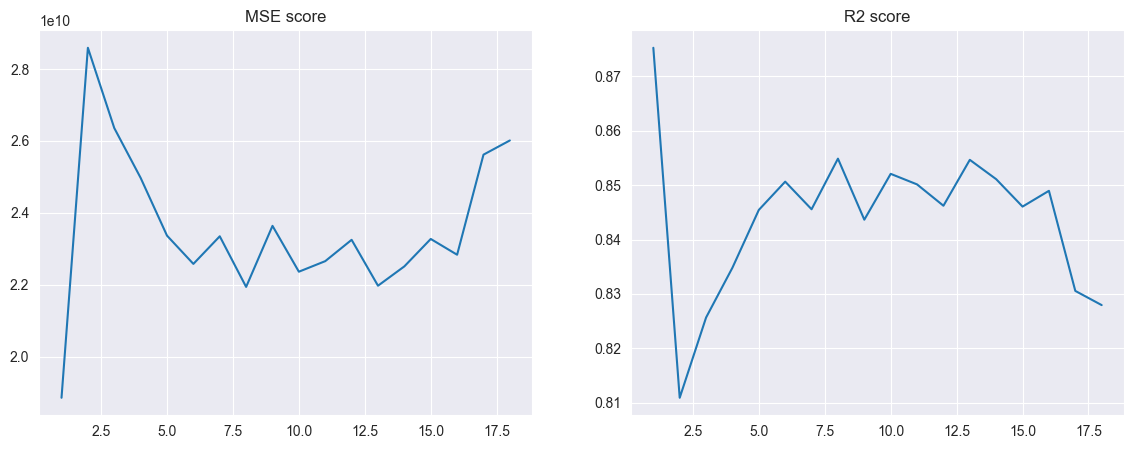

In [10]:
_, ax = plt.subplots(ncols=2, figsize=(14, 5))

ax[0].plot(feat_cnt, mse_score_ls)
ax[0].set_title('MSE score')

ax[1].plot(feat_cnt, r2_score_ls)
ax[1].set_title('R2 score')